Data is in the csv files saved in capstone-project1-data-wrangling.ipynb:

ice_final.csv - for ice

CO2_final.csv - for CO2

fire_M6_final.csv and fire_V1_final.csv - for fire

The M6 dataset has about 20 years of data from Terra and Aqua satellites and the V1 dataset has only 8 years of data from Suomi satellite.


Since the instruments and resolutions are different and I don't want to lose 12 years of data,
there will be two separate datasets for fire data

In [1]:
ls -ltrh ./Data/ice

total 25856
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 11:58 N_seaice_extent_daily_v3.0.csv
-rw-rw-rw-  1 bogdan  staff   2.2M Oct 24 12:03 S_seaice_extent_daily_v3.0.csv
-rw-rw-rw-@ 1 bogdan  staff   3.2M Oct 24 12:05 Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
-rw-r--r--  1 bogdan  staff   4.6M Nov 24 13:39 ice_final.csv


In [2]:
ls -ltrh ./Data/co2

total 224
-rw-r--r--@ 1 bogdan  staff    48K Nov 11 21:44 monthly_in_situ_co2.csv
-rw-r--r--@ 1 bogdan  staff    29K Nov 21 18:58 co2_mm_mlo.csv
-rw-r--r--  1 bogdan  staff    27K Nov 23 20:18 CO2_final.csv


In [3]:
ls -ltrh ./Data/fire/*.csv

-rw-r--r--@ 1 bogdan  staff    50M Nov 24 12:56 ./Data/fire/fire_M6_final.csv
-rw-r--r--@ 1 bogdan  staff    85M Nov 24 13:03 ./Data/fire/fire_V1_final.csv


In [4]:
import numpy as np
import pandas as pd
import random
import os
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Load fire data
# I won't set the index to the date column because there are several observations for each date
# The observations are ordered by date and for the same date they are ordered by decimal_time
fire_M6=pd.read_csv('./Data/fire/fire_M6_final.csv', index_col = False)
fire_V1=pd.read_csv('./Data/fire/fire_V1_final.csv', index_col = False)

In [6]:
fire_M6.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2000-11-01,26.8,-20.8650,146.3039,0.01181,317.00,True,False,False
1,2000-11-01,68.8,-20.5602,146.0194,0.01181,319.95,False,True,False
2,2000-11-01,7.1,-24.3197,151.5619,0.01250,311.15,False,True,False


In [7]:
fire_V1.head(3)

,acq_date,frp,latitude,longitude,decimal_time,mean_brightness,low_confidence,medium_confidence,high_confidence
0,2012-01-31,0.9,11.81456,4.97983,0.05208,298.45,False,True,False
1,2012-01-31,1.3,10.39675,13.45527,0.05208,302.25,False,True,False
2,2012-01-31,1.9,13.73985,13.83765,0.05208,301.80,False,True,False


In [8]:
# Load CO2 data
CO2=pd.read_csv('./Data/CO2/CO2_final.csv', index_col = False)

In [9]:
CO2.head(3)

,Year,Month,decimal_date,CO2_ppm,trend
0,1958,3,1958.208,315.71,314.62
1,1958,4,1958.292,317.45,315.29
2,1958,5,1958.375,317.50,314.71


In [10]:
# There is still a problem with the dates of the observations. For CO2 there are monthly observations.
# Furthermore, the difference from one month to another can be signifficant, for example
# there are 315.71 ppm in March 1958 and 317.45 ppm in April 1958. The data must be interpolated
# before making any correlation with fire data

In [11]:
# Load ice data
ice=pd.read_csv('./Data/ice/ice_final.csv', index_col = False)
ice = ice.set_index('Unnamed: 0')
ice.index.name = None

In [12]:
ice.head(3)

,Baffin-Area-km^2,Baffin-Extent-km^2,Barents-Area-km^2,Barents-Extent-km^2,Beaufort-Area-km^2,Beaufort-Extent-km^2,Bering-Area-km^2,Bering-Extent-km^2,CanadianArchipelago-Area-km^2,CanadianArchipelago-Extent-km^2,...,Kara-Area-km^2,Kara-Extent-km^2,Laptev-Area-km^2,Laptev-Extent-km^2,Okhotsk-Area-km^2,Okhotsk-Extent-km^2,St-Lawrence-Area-km^2,St-Lawrence-Extent-km^2,extent_north,extent_south
1978-10-28,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4200,17.8030
1978-10-29,416908.720,521862.289,222781.361,361743.416,895310.805,940219.39,11472.805,35555.883,719220.320,761228.252,...,569610.622,815398.750,802884.363,872414.226,16799.581,35135.582,0.0,0.0,10.4885,17.7365
1978-10-30,419829.102,531533.703,229769.256,379395.172,894088.098,940219.39,13553.099,42670.305,717303.629,761228.252,...,562328.391,816017.367,806760.991,872414.226,18745.308,39102.698,0.0,0.0,10.5570,17.6700


Exploratory Data Analysis (EDA)

There are two stages:
1. Explore individual datasets: fire, CO2, ice
2. Merge the data in one big dataset and explore it

EDA - Fire

In [36]:
# TODO:
# put something here :)

EDA - CO2

There is a trend and a seasonal component, as shown below

<Figure size 432x288 with 0 Axes>

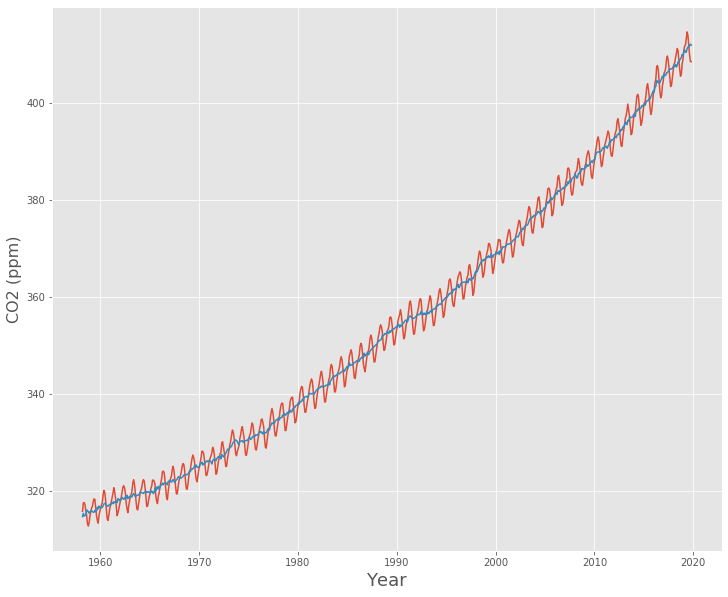

In [15]:
plt.style.use('ggplot')
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(CO2['decimal_date'], CO2['CO2_ppm'])
plt.plot(CO2['decimal_date'], CO2['trend'])
fig.suptitle('CO2 Data', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 (ppm)', fontsize=16)
plt.show()

In [16]:
# Need to use .values for transforming the pandas series to a numpy array
# and use numpy specific functions for 1d arrays
print(type(CO2['CO2_ppm']))
print(type(CO2['CO2_ppm'].values))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [18]:
# get local maximums and minimums
maximums = argrelextrema(CO2['CO2_ppm'].values, np.greater_equal)[0]
minimums = argrelextrema(CO2['CO2_ppm'].values, np.less_equal)[0]

print('Local Maximums\n', maximums, '\n Number of maximums = ', len(maximums), '\n')
print('Local Minimums\n', minimums, '\n Number of minimums = ', len(minimums))

Local Maximums
 [  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 507 518 530 542 554 566 578 590 602 614 626
 638 650 662 674 686 698 710 722 734] 
 Number of maximums =  63 

Local Minimums
 [  0   7  19  31  42  55  67  78  91 103 114 115 127 139 150 162 174 187
 199 211 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402
 414 426 438 451 462 474 486 498 506 510 522 535 547 558 570 582 594 607
 619 630 643 655 666 678 690 702 714 726 739] 
 Number of minimums =  65


Because I used np.greater_equal and np.less_equal in order not to lose flat maximums/minimums, there are 3 values to be deleted from minimums: the first value, the last value, the 11-th value (it is a flat minimum, the minimum is duplicated)

In [19]:
minimums = np.delete(minimums, [0, 11, 64])
print('Local Minimums\n', minimums, '\n Length minimums = ', len(minimums))

Local Minimums
 [  7  19  31  42  55  67  78  91 103 114 127 139 150 162 174 187 199 211
 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402 414 426
 438 451 462 474 486 498 506 510 522 535 547 558 570 582 594 607 619 630
 643 655 666 678 690 702 714 726] 
 Length minimums =  62


The local CO2 maximums are reached around each 12 months, during the winter in the Northern Hemisphere. The Northern Hemisphere contains 68% of the Earth's land area and during the winter there is less CO2 eliminated by the Northern forests. Therefore local maximums for CO2 are located around the end of winter while local minimums are located around the end of summer as shown in the diagram below

<Figure size 432x288 with 0 Axes>

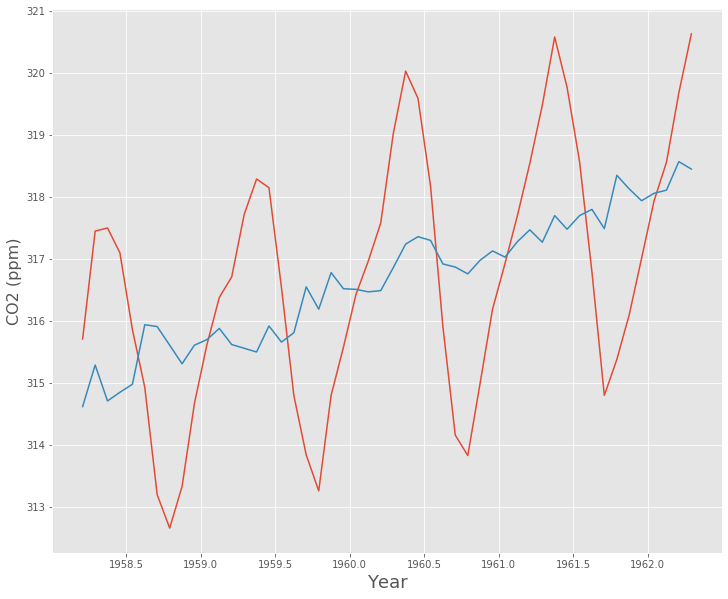

In [20]:
plt.style.use('ggplot')
detail_df=CO2.head(50)
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
plt.plot(detail_df['decimal_date'], detail_df['trend'])
fig.suptitle('CO2 Data', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 (ppm)', fontsize=16)
plt.show()

One issue is the local variability or data reading errors that can create local minimums or maximums if these are defined by using only 3 succesive values, for example: low/high/low for a local maximum and high/low/high for a local minimum. The proper solution is to use numpy.convolve(): https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html and https://en.wikipedia.org/wiki/Convolution but this is outside the scope of this first capstone project.

The easy fix is just to look at the data and fix the issues manually. In the diagram below there is a clear exception in the middle, where we can see 2 local maximums during the spring of year 2000

<Figure size 432x288 with 0 Axes>

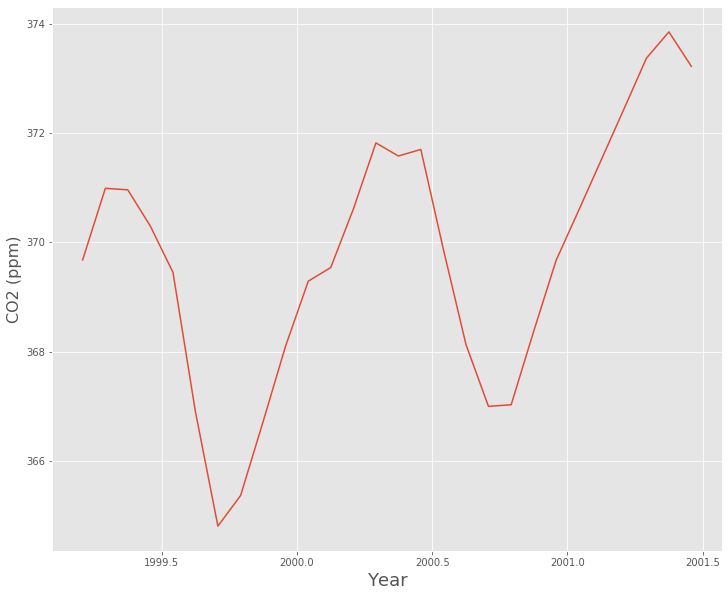

In [21]:
detail_df=CO2[492:520]
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
fig.suptitle('CO2 Data', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 (ppm)', fontsize=16)
plt.show()

This exception is shown in the data for rows 505 and 507. Row 507 will be deleted from maximums list

In [23]:
print(CO2.iloc[504]['CO2_ppm'], CO2.iloc[505]['CO2_ppm'], CO2.iloc[506]['CO2_ppm'],
      CO2.iloc[507]['CO2_ppm'], CO2.iloc[508]['CO2_ppm'])

370.6 371.82 371.58 371.7 369.86


In [24]:
print(maximums)

[  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 507 518 530 542 554 566 578 590 602 614 626
 638 650 662 674 686 698 710 722 734]


In [25]:
maximums = np.delete(maximums, 43)
print(maximums)

[  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 518 530 542 554 566 578 590 602 614 626 638
 650 662 674 686 698 710 722 734]


The minimum value just before 43 must also be deleted from minimums list

In [26]:
minimums = np.delete(minimums, 42)

Another issue is the lack of a local minimum at the end of the time series as shown below:

<Figure size 432x288 with 0 Axes>

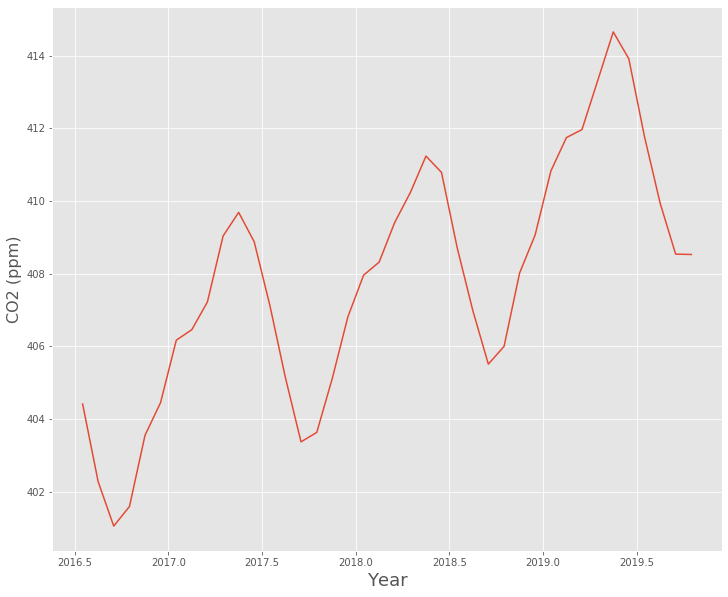

In [27]:
detail_df=CO2[700:]
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(detail_df['decimal_date'], detail_df['CO2_ppm'])
fig.suptitle('CO2 Data', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 (ppm)', fontsize=16)
plt.show()

From the shape of this diagram, it is clear that the last reading represents the local minimum. The local minimum is reached each year in September or October.

Therefore, I shall insert the last index value from the time series as a local minimum.

In [28]:
print(CO2.iloc[737]['CO2_ppm'], CO2.iloc[738]['CO2_ppm'], CO2.iloc[739]['CO2_ppm'])

409.95 408.54 408.53


In [29]:
minimums = np.append(minimums, 739)
print('Local Maximums\n', maximums, '\n Number of maximums = ', len(maximums), '\n')
print('Local Minimums\n', minimums, '\n Number of minimums = ', len(minimums))

Local Maximums
 [  2  14  26  38  50  62  74  86  98 110 122 134 145 158 170 182 194 206
 218 230 242 255 266 278 290 302 314 326 338 350 362 374 386 398 410 422
 434 446 458 470 482 493 505 518 530 542 554 566 578 590 602 614 626 638
 650 662 674 686 698 710 722 734] 
 Number of maximums =  62 

Local Minimums
 [  7  19  31  42  55  67  78  91 103 114 127 139 150 162 174 187 199 211
 223 235 246 258 271 282 294 306 318 331 343 354 366 378 390 402 414 426
 438 451 462 474 486 498 510 522 535 547 558 570 582 594 607 619 630 643
 655 666 678 690 702 714 726 739] 
 Number of minimums =  62


Check if maximums and minimums alternate

In [30]:
alternate = True
for item in zip(maximums, minimums):
    # each tuple must start with a maximum and end with a minimum
    # if the position of the maximum is greater than the position of minimum, the values do not alternate properly
    if item[0] >= item[1]:
        alternate = False
        break
print(alternate)

True


Therefore, the maximums and minimums alternate as expected

Create a list of differences between the local maximum and local minimum for each year

In [32]:
yearly_co2_diff = []
for item in zip(maximums, minimums):
    yearly_co2_diff.append(round(CO2.iloc[item[0]]['CO2_ppm'] - CO2.iloc[item[1]]['CO2_ppm'], 3))

<Figure size 432x288 with 0 Axes>

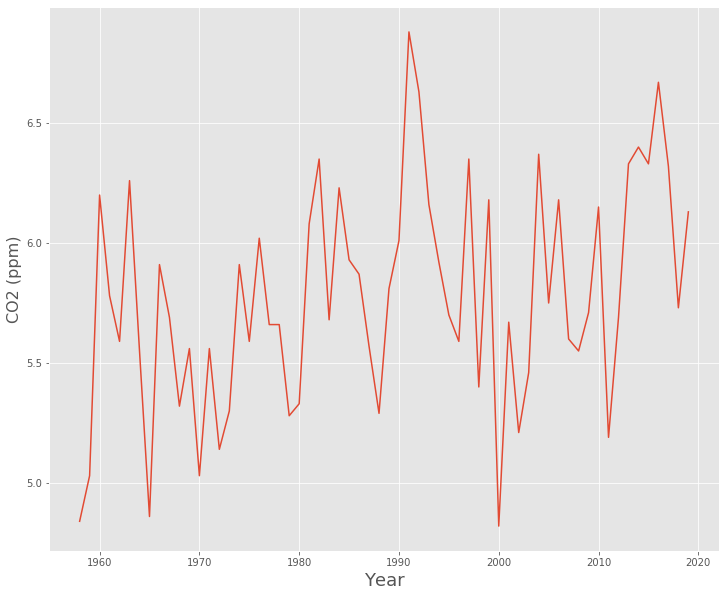

In [33]:
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(range(1958, 2020), yearly_co2_diff)
fig.suptitle('Yearly max CO2 difference', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('CO2 (ppm)', fontsize=16)
#plt.legend('Yearly CO2 differences')
plt.show()

It looks like there is a positive trend for this difference. This hypotesis must be tested:

In [34]:
co2_diff=pd.DataFrame()
co2_diff['Year']=range(1958, 2020)
co2_diff['CO2 difference']=yearly_co2_diff

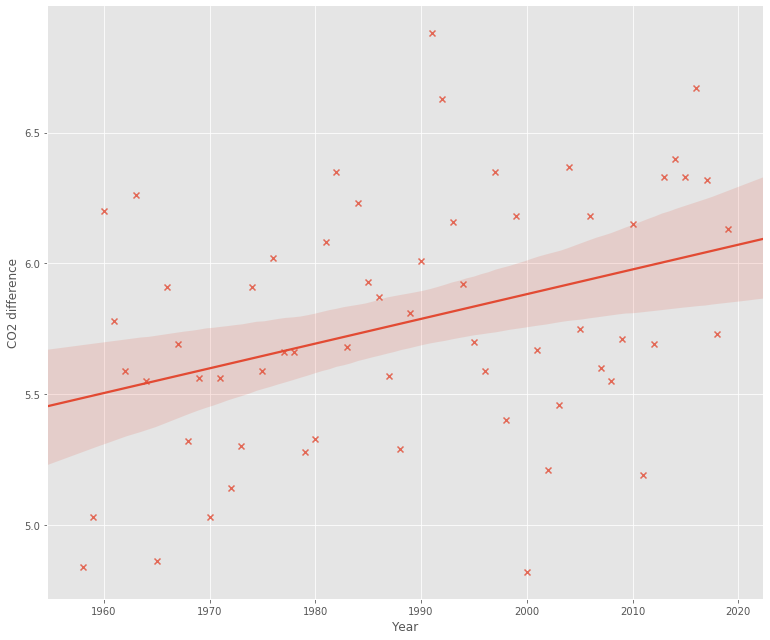

In [35]:
sns.lmplot(x='Year', y='CO2 difference', data=co2_diff, aspect=1.2, height=9, markers='x')

There positive trend for yearly CO2 differences is confirmed.

TODO: calculate R2, p-value,... show some numbers not just a diagram

In [37]:
# Check the CO2 trend by ignoring the yearly variance

In [39]:
CO2.set_index('decimal_date')

,Year,Month,CO2_ppm,trend
decimal_date,,,,
1958.208,1958,3,315.71,314.62
1958.292,1958,4,317.45,315.29
1958.375,1958,5,317.50,314.71
1958.458,1958,6,317.10,314.85
1958.542,1958,7,315.86,314.98
1958.625,1958,8,314.93,315.94
1958.708,1958,9,313.20,315.91
1958.792,1958,10,312.66,315.61
1958.875,1958,11,313.33,315.31


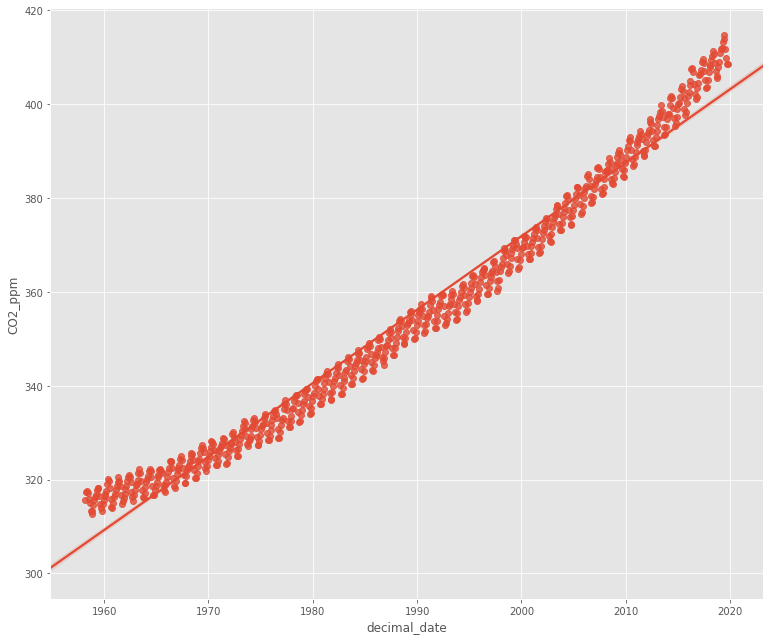

In [40]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=1, palette="RdBu")

A simple order 1 regression is not a good fit for the data

An order 2 regression is a much better fit for the data

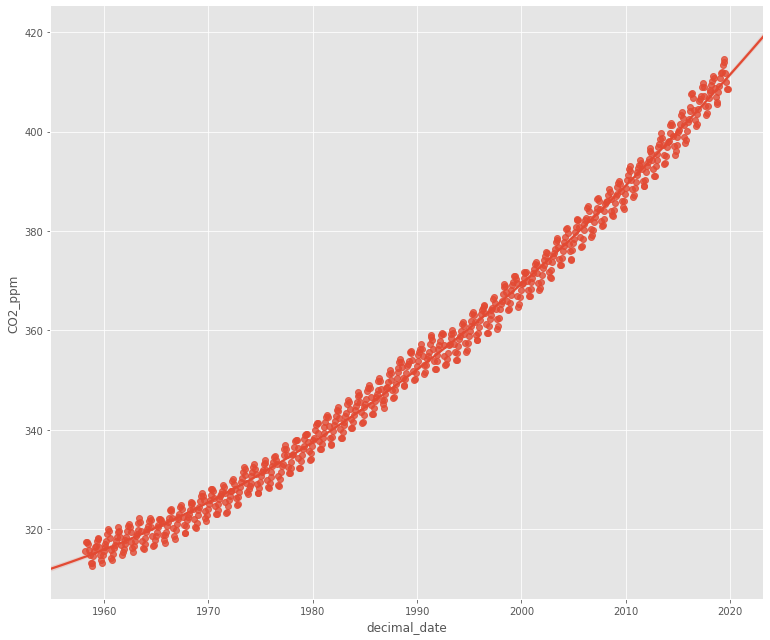

In [45]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=2, palette="RdBu")

Check if an order 3 is a better fit

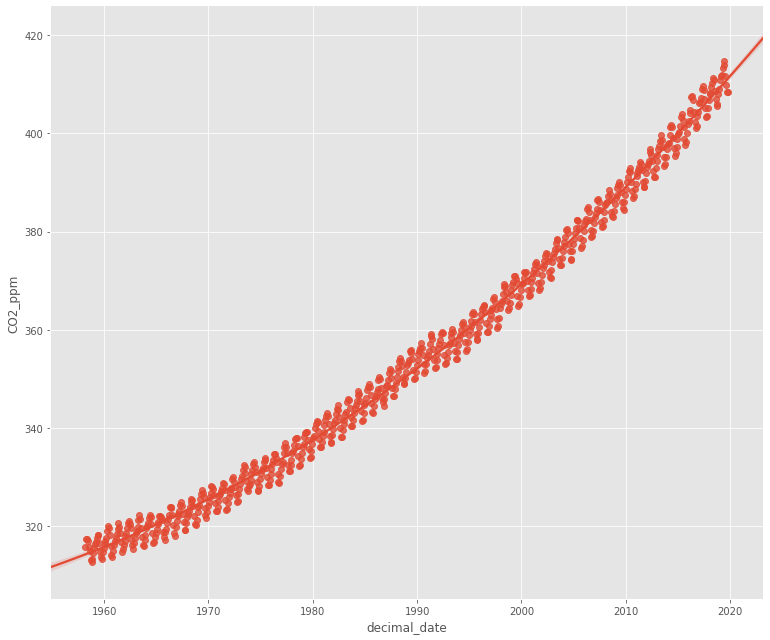

In [46]:
sns.lmplot(x='decimal_date', y='CO2_ppm', data=CO2, aspect=1.2, height=9, order=3, palette="RdBu")

Maybe this diagram can catch better the anomaly between 1990 and 1995 when CO2 was not increasing as before - but a decision must be taken by calculating the residuals

In [47]:
# tests :)

In [48]:
import statsmodels.api as sm
Y = [1,3,4,5,2,3,4]
X = range(1,8)
X = sm.add_constant(X)

In [49]:
X

array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.],
       [1., 5.],
       [1., 6.],
       [1., 7.]])

In [50]:
model = sm.OLS(Y,X)
results = model.fit()

In [51]:
results.params

array([2.14285714, 0.25      ])

In [52]:
results.tvalues

array([1.87867287, 0.98019606])

In [53]:
print(results.t_test([1, 0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             2.1429      1.141      1.879      0.119      -0.789       5.075


In [54]:
print(results.f_test(np.identity(2)))

<F test: F=array([[19.46078431]]), p=0.004372505910945679, df_denom=5, df_num=2>


<Figure size 432x288 with 0 Axes>

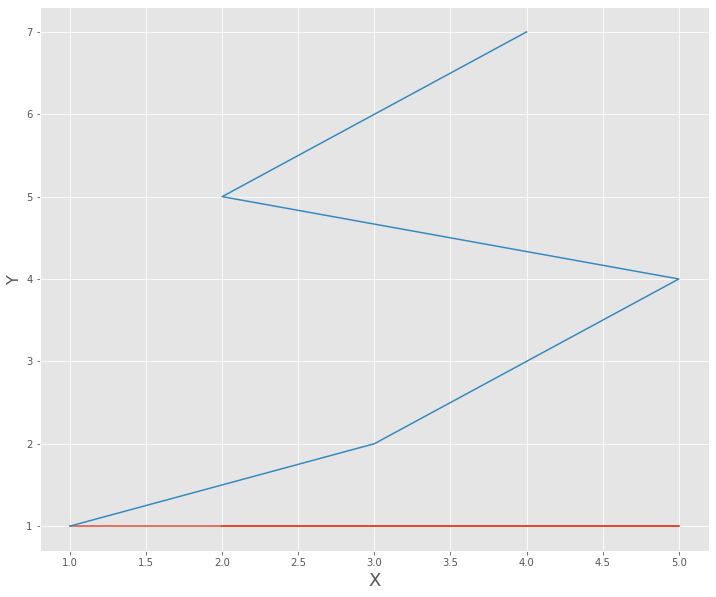

In [55]:
fig = plt.figure()
plt.figure(figsize=(12, 10))
plt.plot(Y, X)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=16)
plt.show()

EDA - ice

In [ ]:
# Will show the map for every sea in the ice dataset...

<img src="Kara_Sea_map.png">

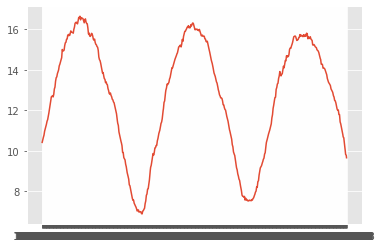

In [57]:
# There is a clear seasonal component if the plot is for more than 1 year
plt.plot(ice['extent_north'].head(1000))

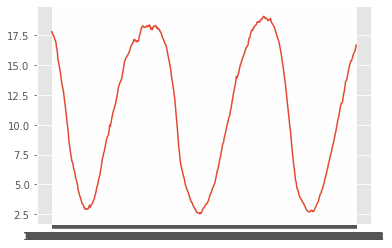

In [59]:
# As expected, north and south ice values are negatively correlated
plt.plot(ice['extent_south'].head(1000))

In [60]:
# check .corr(), draw a heatmap for all the seas in the dataset